In [1]:
# Sean O'Connor 2022

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import itertools

plt.style.use('seaborn-poster')

%matplotlib inline

In [113]:
def unfoldX(v):
    v1 = np.array([v[i] for i in range(VertexArea)])
    return np.transpose(np.reshape(v1, (1, -1)))

def refoldX(v):
    return list(np.ndarray.flatten(v))

def unfoldVectorX(v):
    v1 = np.array([v[i] for i in range(VertexArea)])
    v2 = []
    index = 0
    for i in range(GraphVertices):
        v2.append(np.transpose(np.reshape(np.array([v[j + index] for j in range(VertexStalks[i])]), (1, -1))))
        index += len(v2[i])
    return v2

def refoldVectorX(v):
    v1 = []
    for vect in v:
        v1.append(list(np.ndarray.flatten(vect)))
    return list(itertools.chain.from_iterable(v1))

def unfoldFIn(v):
    v1 = np.array([v[i + VertexArea] for i in range(InEdgesArea)])
    v2 = []
    index = 0
    for i in range(GraphEdges):
        v2.append(np.reshape(np.array([v1[j + index] for j in range(InRestrictionMapsArea[i])]), (EdgeStalks[i], -1)))
        index += len(np.ndarray.flatten(v2[i]))
    return v2

def refoldFIn(v):
    v1 = []
    for vect in v:
        v1.append(list(np.ndarray.flatten(vect)))
    return list(itertools.chain.from_iterable(v1))

def unfoldFOut(v):
    v1 = np.array([v[i + VertexArea + InEdgesArea] for i in range(OutEdgesArea)])
    v2 = []
    index = 0
    for i in range(GraphEdges):
        v2.append(np.reshape(np.array([v1[j + index] for j in range(OutRestrictionMapsArea[i])]), (EdgeStalks[i], -1)))
        index += len(np.ndarray.flatten(v2[i]))
    return v2

def refoldFOut(v):
    v1 = []
    for vect in v:
        v1.append(list(np.ndarray.flatten(vect)))
    return list(itertools.chain.from_iterable(v1))

def refold(X, FIn, FOut):
    return np.array(refoldX(X) + refoldFIn(FIn) + refoldFOut(FOut))

def coboundaryfunction(FIn, FOut, VectorX): 
    return [np.subtract(np.matmul(FIn[i], VectorX[InEdges[i]]), 
                        np.matmul(FOut[i], VectorX[OutEdges[i]])) for i in range(GraphEdges)]

def Basis(j):
    v1 = [1 if i == j else 0 for i in range(VertexArea)]
    return np.transpose(np.reshape(np.array(v1), (1, -1)))

def BasisVector(j):
    return unfoldVectorX(refoldX(Basis(j)))

def flatten(v):
    return list(itertools.chain.from_iterable([list(itertools.chain.from_iterable([np.ravel(y) for y in x])) for x in v]))

def coboundarymatrix(FIn, FOut):
    v1 = flatten([coboundaryfunction(FIn, FOut, BasisVector(i)) for i in range(VertexArea)])
    return np.transpose(np.reshape(np.array(v1), (VertexArea, EdgeArea)))

def laplacian(FIn, FOut):
    delta = coboundarymatrix(FIn, FOut)
    return np.matmul(np.transpose(delta), delta)

def dX(FIn, FOut, X):
    return -alpha * np.matmul(laplacian(FIn, FOut), X)

def dFIn(FIn, FOut, VectorX):
    return -beta * np.array([np.matmul(np.subtract(np.matmul(FIn[i], VectorX[InEdges[i]]), 
                                                   np.matmul(FOut[i], VectorX[OutEdges[i]])), 
                                       np.transpose(VectorX[InEdges[i]])) for i in range(GraphEdges)])

    
def dFOut(FIn, FOut, VectorX):
    return -beta * np.array([np.matmul(np.subtract(np.matmul(FOut[i], VectorX[OutEdges[i]]), 
                                                   np.matmul(FIn[i], VectorX[InEdges[i]])), 
                                       np.transpose(VectorX[OutEdges[i]])) for i in range(GraphEdges)])

def change(v):
    X = unfoldX(v)
    VectorX = unfoldVectorX(v)
    FIn = unfoldFIn(v)
    FOut = unfoldFOut(v)
    
    newX = dX(FIn, FOut, X)
    newFIn = dFIn(FIn, FOut, VectorX)
    newFOut = dFOut(FIn, FOut, VectorX)
    
    return refold(newX, newFIn, newFOut)

def display(final):
    VectorX = unfoldVectorX(final)
    FIn = unfoldFIn(final)
    FOut = unfoldFOut(final)
    
    for i in range(GraphVertices):
        print("Value of Vertex " + str(i) + ":\n" + str(VectorX[i]) + "\n")
    
    for i in range(GraphEdges):
        print("Restriction Map from Vertex " + str(InEdges[i]) + " to Edge " + str(i) + ":\n" + str(FIn[i]) + "\n")
        print("Restriction Map from Vertex " + str(OutEdges[i]) + " to Edge " + str(i) + ":\n" + str(FOut[i]) + "\n")

def compare(initial, final):
    InitialVectorX = unfoldVectorX(initial)
    InitialFIn = unfoldFIn(initial)
    InitialFOut = unfoldFOut(initial)
    
    FinalVectorX = unfoldVectorX(final)
    FinalFIn = unfoldFIn(final)
    FinalFOut = unfoldFOut(final)
    
    
    for i in range(GraphVertices):
        print("Initial Value of Vertex " + str(i) + ":\n" + str(InitialVectorX[i]) + "\n")
        print("Final Value of Vertex " + str(i) + ":\n" + str(FinalVectorX[i]) + "\n")
    
    for i in range(GraphEdges):
        print("Initial Restriction Map from Vertex " + str(InEdges[i]) + " to Edge " + str(i) + ":\n" + str(InitialFIn[i]) + "\n")
        print("Final Restriction Map from Vertex " + str(InEdges[i]) + " to Edge " + str(i) + ":\n" + str(FinalFIn[i]) + "\n")
        print("Initial Restriction Map from Vertex " + str(OutEdges[i]) + " to Edge " + str(i) + ":\n" + str(InitialFOut[i]) + "\n")
        print("Final Restriction Map from Vertex " + str(OutEdges[i]) + " to Edge " + str(i) + ":\n" + str(FinalFOut[i]) + "\n")




In [114]:
# Preset from Paper

GraphVertices = 4
GraphEdges = 4

InEdges = np.array([0, 1, 2, 3])
OutEdges = np.array([1, 2, 3, 0])

VertexStalks = np.array([1, 2, 1, 2])
EdgeStalks = np.array([1, 1, 1, 2])

alpha = 1
beta = 0

initial = np.array([1, 1, 1, 1, 1, 1, -2, 1, 1, -1, 1, -1, 1, 0, -1, 2, 1, 1, -1, 1, 0])

t1 = 10


# Do not modify below

InRestrictionMapsArea = np.array([EdgeStalks[i] * VertexStalks[InEdges[i]] for i in range(GraphEdges)])
OutRestrictionMapsArea = np.array([EdgeStalks[i] * VertexStalks[OutEdges[i]] for i in range(GraphEdges)])

VertexArea = np.sum(VertexStalks)
EdgeArea = np.sum(EdgeStalks)

InEdgesArea = np.sum(InRestrictionMapsArea)
OutEdgesArea = np.sum(OutRestrictionMapsArea)

assert GraphVertices == len(VertexStalks)
assert GraphEdges == len(InEdges) == len(OutEdges) == len(EdgeStalks)
assert VertexArea + InEdgesArea + OutEdgesArea == len(initial)

In [115]:
# Modify Below

GraphVertices = 3
GraphEdges = 3

InEdges = np.array([0, 1, 2])
OutEdges = np.array([1, 2, 0])

VertexStalks = np.array([1, 1, 1])
EdgeStalks = np.array([1, 1, 1])

alpha = 0.1
beta = 1

initial = np.array([-1, 3, 1, 1, 1, 1, 1, 1, 1])

t1 = 3


# Do not modify below

InRestrictionMapsArea = np.array([EdgeStalks[i] * VertexStalks[InEdges[i]] for i in range(GraphEdges)])
OutRestrictionMapsArea = np.array([EdgeStalks[i] * VertexStalks[OutEdges[i]] for i in range(GraphEdges)])

VertexArea = np.sum(VertexStalks)
EdgeArea = np.sum(EdgeStalks)

InEdgesArea = np.sum(InRestrictionMapsArea)
OutEdgesArea = np.sum(OutRestrictionMapsArea)

assert GraphVertices == len(VertexStalks)
assert GraphEdges == len(InEdges) == len(OutEdges) == len(EdgeStalks)
assert VertexArea + InEdgesArea + OutEdgesArea == len(initial)

In [116]:
F = lambda t, v: change(v)

sol = solve_ivp(F, (0, t1), initial)

final = np.array([x[-1] for x in sol.y])

compare(initial, final)

Initial Value of Vertex 0:
[[-1]]

Final Value of Vertex 0:
[[-0.91536715]]

Initial Value of Vertex 1:
[[3]]

Final Value of Vertex 1:
[[2.97002202]]

Initial Value of Vertex 2:
[[1]]

Final Value of Vertex 2:
[[0.97197358]]

Initial Restriction Map from Vertex 0 to Edge 0:
[[1]]

Final Restriction Map from Vertex 0 to Edge 0:
[[0.61364075]]

Initial Restriction Map from Vertex 1 to Edge 0:
[[1]]

Final Restriction Map from Vertex 1 to Edge 0:
[[-0.18904153]]

Initial Restriction Map from Vertex 1 to Edge 1:
[[1]]

Final Restriction Map from Vertex 1 to Edge 1:
[[0.39376675]]

Initial Restriction Map from Vertex 2 to Edge 1:
[[1]]

Final Restriction Map from Vertex 2 to Edge 1:
[[1.20271462]]

Initial Restriction Map from Vertex 2 to Edge 2:
[[1]]

Final Restriction Map from Vertex 2 to Edge 2:
[[-0.01890076]]

Initial Restriction Map from Vertex 0 to Edge 2:
[[1]]

Final Restriction Map from Vertex 0 to Edge 2:
[[0.02936975]]



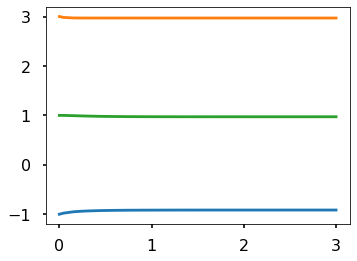

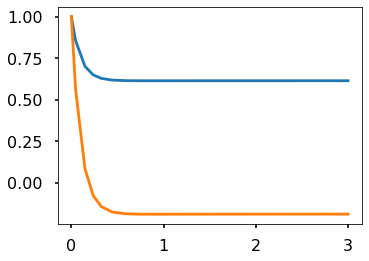

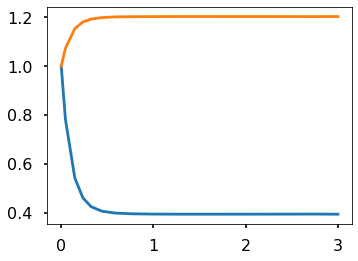

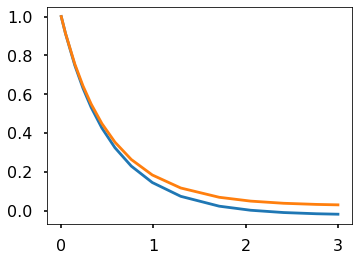

In [126]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(sol.t, sol.y[0])
plt.plot(sol.t, sol.y[1])
plt.plot(sol.t, sol.y[2])

plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(sol.t, sol.y[3])
plt.plot(sol.t, sol.y[6])

plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(sol.t, sol.y[4])
plt.plot(sol.t, sol.y[7])

plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(sol.t, sol.y[5])
plt.plot(sol.t, sol.y[8])